In [22]:
import wbgapi as wb
import wbdata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import RANSACRegressor
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score


<h1 style="color:black; background-color:white; padding:10px; padding-bottom:10px;text-align: center;">To be rich or to be green</h1>

---

In [4]:
def load_and_name_db_WB(db, *args):
    global df_name
    df_name = db
    globals()[df_name] = wb.data.DataFrame(value1, wb.region.members(value2), range(value3, value4))
    globals()[df_name].columns = new_column_names
    return globals()[df_name]

In [5]:
value1 = ['EN.ATM.CO2E.PC','SL.GDP.PCAP.EM.KD']
new_column_names = ['CO2_per_capita', "GDP_per_capita"]
value2 = "WLD"
value3 = 2019
value4 = 2020

load_and_name_db_WB("df_original", value1, value2, value3, value4, new_column_names)

,CO2_per_capita,GDP_per_capita
economy,,
ABW,NaN,NaN
AFG,0.160850,8842.504595
AGO,0.779292,17314.051641
ALB,1.691968,30717.371022
AND,6.573595,NaN
...,...,...
XKX,NaN,NaN
YEM,0.351701,NaN
ZAF,7.568640,44759.518380


In [23]:
def plot_ransac_regression(db_name, start_year, end_year):
    num_years = end_year - start_year + 1
    num_rows = (num_years - 1) // 3 + 1
    num_cols = min(num_years, 3)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig.tight_layout(pad=5.0)
    
    for year in range(start_year, end_year + 1):
        data = db_name.dropna()
        
        # Check if data contains at least one valid data point
        if data.shape[0] > 0:
            # Fit RANSACRegressor
            ransac = RANSACRegressor()
            ransac.fit(data[['CO2_per_capita']], data['GDP_per_capita'])
            
            # Obtain inlier and outlier mask
            inlier_mask = ransac.inlier_mask_
            outlier_mask = np.logical_not(inlier_mask)
            
            # Extract inlier and outlier data points
            inliers = data[inlier_mask]
            outliers = data[outlier_mask]
            
            # Calculate R-squared score
            r2 = ransac.score(data[['CO2_per_capita']], data['GDP_per_capita'])
            
            # Plot data points, regression line, and annotate R-squared score
            row = (year - start_year) // 3
            col = (year - start_year) % 3
            ax = axes[row, col] if num_rows > 1 else axes[col]
            ax.scatter(data['CO2_per_capita'], data['GDP_per_capita'], color='blue', label='Data Points')
            ax.scatter(outliers['CO2_per_capita'], outliers['GDP_per_capita'], color='red', label='Outliers')
            ax.plot(data['CO2_per_capita'], ransac.predict(data[['CO2_per_capita']]), color='green', label='RANSAC Regression Line')
            ax.set_xlabel('CO2_per_capita', fontsize=12)
            ax.set_ylabel('GDP_per_capita', fontsize=12)
            ax.set_title(f'RANSAC Regression {year}-{year+1}', fontsize=14)
            ax.annotate(f'R-squared = {r2:.2f}', xy=(0.5, 0.1), xycoords='axes fraction', fontsize=12)
            ax.legend(fontsize=12)
    
    plt.show()

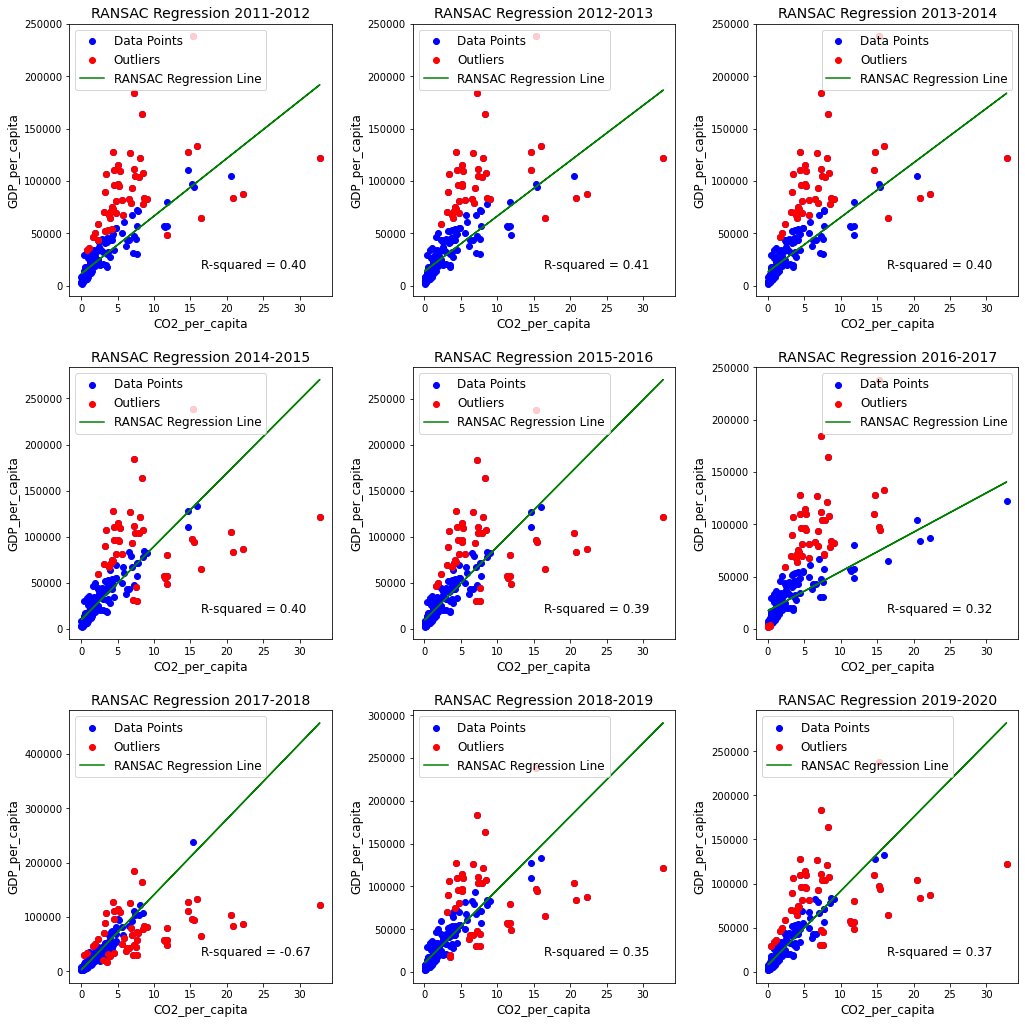

In [17]:
plot_ransac_regression(df_original, 2011, 2019)

In [24]:
def plot_regression_analysis(data, column1, column2):
    transformations = ['log', 'sqrt']  # Add more transformations if needed
    data = data.dropna()

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    fig.tight_layout()

    # Iterate over transformations
    for i, transformation in enumerate(transformations):
        # Apply data transformation
        if transformation == 'log':
            transformed_x = np.log(data[column1])
            transformed_y = np.log(data[column2])
        elif transformation == 'sqrt':
            transformed_x = np.sqrt(data[column1])
            transformed_y = np.sqrt(data[column2])
        else:
            continue

        # Fit a RANSACRegressor model to the transformed data
        ransac = RANSACRegressor()
        ransac.fit(transformed_x.values.reshape(-1, 1), transformed_y)

        # Obtain the inlier and outlier mask
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)

        # Extract the inlier and outlier data points
        inliers_x = transformed_x[inlier_mask]
        inliers_y = transformed_y[inlier_mask]
        outliers_x = transformed_x[outlier_mask]
        outliers_y = transformed_y[outlier_mask]

        # Calculate the R-squared score for the regression line
        r2 = ransac.score(transformed_x.values.reshape(-1, 1), transformed_y)

        # Visualize the data points, regression line, and annotate the R-squared score
        row = i // 2
        col = i % 2
        axs[row, col].scatter(transformed_x, transformed_y, color='blue', label='Data Points')
        axs[row, col].scatter(outliers_x, outliers_y, color='red', label='Outliers')
        axs[row, col].plot(transformed_x, ransac.predict(transformed_x.values.reshape(-1, 1)), color='green',
                           label='RANSAC Regression Line')
        axs[row, col].set_xlabel('CO2pcap_' + transformation, fontsize=12)
        axs[row, col].set_ylabel('GDP_per_person_' + transformation, fontsize=12)
        axs[row, col].set_title('RANSAC Regression (' + transformation + ' transformation)', fontsize=14)
        axs[row, col].annotate(f'R-squared = {r2:.2f}', xy=(0.6, 0.1), xycoords='axes fraction', fontsize=12)
        axs[row, col].legend(fontsize=12)

    # Weighted Least Squares (WLS)
    wls = sm.WLS(transformed_y, sm.add_constant(transformed_x)).fit()
    wls_pred = wls.predict(sm.add_constant(transformed_x))
    r2_wls = r2_score(transformed_y, wls_pred)
    axs[-2, 0].scatter(transformed_x, transformed_y, color='blue', label='Data Points')
    axs[-2, 0].plot(transformed_x, wls_pred, color='green', label='WLS Regression Line')
    axs[-2, 0].set_xlabel('CO2pcap', fontsize=12)
    axs[-2, 0].set_ylabel('GDP_per_person', fontsize=12)
    axs[-2, 0].set_title('Weighted Least Squares (WLS) Regression', fontsize=14)
    axs[-2, 0].annotate(f'R-squared = {r2_wls:.2f}', xy=(0.6, 0.1), xycoords='axes fraction', fontsize=12)
    axs[-2, 0].legend(fontsize=12)

    # Robust Standard Errors
    ols = sm.OLS(transformed_y, sm.add_constant(transformed_x)).fit(cov_type='HC3')
    ols_pred = ols.predict(sm.add_constant(transformed_x))
    r2_robust = r2_score(transformed_y, ols_pred)
    axs[-1, 0].scatter(transformed_x, transformed_y, color='blue', label='Data Points')
    axs[-1, 0].plot(transformed_x, ols_pred, color='green', label='OLS Regression Line')
    axs[-1, 0].set_xlabel('CO2pcap', fontsize=12)
    axs[-1, 0].set_ylabel('GDP_per_person', fontsize=12)
    axs[-1, 0].set_title('Robust Standard Errors Regression', fontsize=14)
    axs[-1, 0].annotate(f'R-squared = {r2_robust:.2f}', xy=(0.6, 0.1), xycoords='axes fraction', fontsize=12)
    axs[-1, 0].legend(fontsize=12)

    # Generalized Least Squares (GLS)
    gls = sm.GLS(transformed_y, sm.add_constant(transformed_x)).fit()
    gls_pred = gls.predict(sm.add_constant(transformed_x))
    r2_gls = r2_score(transformed_y, gls_pred)
    axs[-1, 1].scatter(transformed_x, transformed_y, color='blue', label='Data Points')
    axs[-1, 1].plot(transformed_x, gls_pred, color='green', label='GLS Regression Line')
    axs[-1, 1].set_xlabel('CO2pcap', fontsize=12)
    axs[-1, 1].set_ylabel('GDP_per_person', fontsize=12)
    axs[-1, 1].set_title('Generalized Least Squares (GLS) Regression', fontsize=14)
    axs[-1, 1].annotate(f'R-squared = {r2_gls:.2f}', xy=(0.6, 0.1), xycoords='axes fraction', fontsize=12)
    axs[-1, 1].legend(fontsize=12)

    plt.tight_layout()
    plt.show()

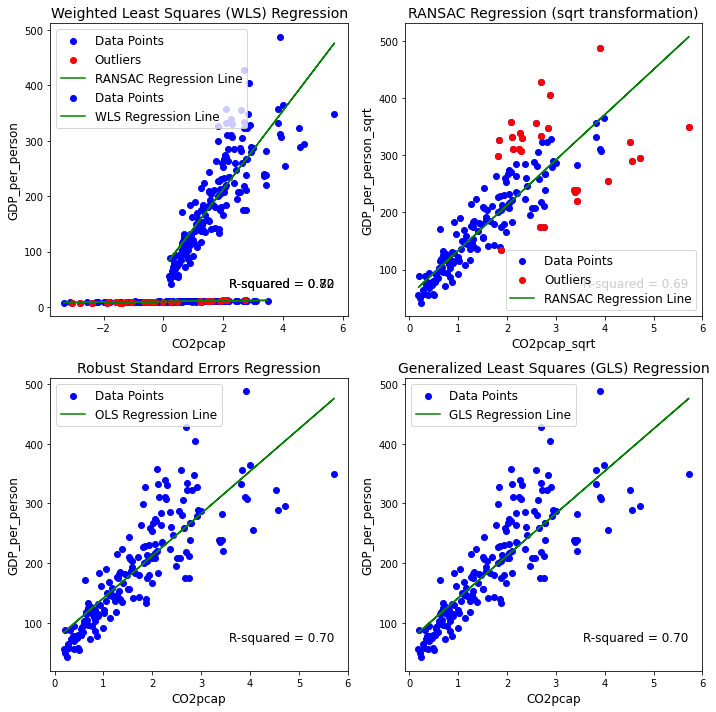

In [25]:
plot_regression_analysis(df_original, "CO2_per_capita",	"GDP_per_capita")

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import r2_score

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import r2_score

def plot_ransac_regression9(data, column1, column2):
    transformations = ['log', 'sqrt', 'reciprocal', 'boxcox']

    fig, axs = plt.subplots(4, 2, figsize=(12, 16))
    fig.tight_layout()

    # Plot original data
    axs[0, 0].scatter(data[column1], data[column2], color='blue', label='Data Points')
    axs[0, 0].set_xlabel(column1)
    axs[0, 0].set_ylabel(column2)
    axs[0, 0].set_title('Original Data')
    axs[0, 0].legend()

    for i, transformation in enumerate(transformations):
        # Apply data transformation
        if transformation == 'log':
            transformed_x = np.log(data[column1])
            transformed_y = np.log(data[column2])
        elif transformation == 'sqrt':
            transformed_x = np.sqrt(data[column1])
            transformed_y = np.sqrt(data[column2])
        elif transformation == 'reciprocal':
            transformed_x = np.sqrt(data[column1])
            transformed_y = np.sqrt(data[column2])
        elif transformation == 'boxcox':
            transformed_x, _ = stats.boxcox(data[column1])
            transformed_y, _ = stats.boxcox(data[column2])
        else:
            continue

        # Drop NaN values
        transformed_data = pd.DataFrame({'X': transformed_x, 'Y': transformed_y})
        transformed_data = transformed_data.dropna()
        
        # Fit a RANSACRegressor model to the transformed data
        ransac = RANSACRegressor()
        ransac.fit(transformed_data['X'].values.reshape(-1, 1), transformed_data['Y'].values)

        # Obtain the inlier and outlier mask
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)

        # Extract the inlier and outlier data points
        inliers_x = transformed_data['X'][inlier_mask]
        inliers_y = transformed_data['Y'][inlier_mask]
        outliers_x = transformed_data['X'][outlier_mask]
        outliers_y = transformed_data['Y'][outlier_mask]

        # Calculate the R-squared score for the regression line
        r2 = ransac.score(transformed_data['X'].values.reshape(-1, 1), transformed_data['Y'].values)

        # Visualize the data points, regression line, and annotate the R-squared score
        row = (i + 1) // 2
        col = (i + 1) % 2
        axs[row, col].scatter(transformed_x, transformed_y, color='blue', label='Data Points')
        axs[row, col].scatter(outliers_x, outliers_y, color='red', label='Outliers')
        valid_mask = ~np.isnan(transformed_x)
        transformed_x_values = transformed_x if isinstance(transformed_x, np.ndarray) else transformed_x.values
        axs[row, col].plot(transformed_x_values[valid_mask].reshape(-1, 1), ransac.predict(transformed_x_values[valid_mask].reshape(-1, 1)), 
                           color='green', label='RANSAC Regression Line')
        axs[row, col].set_xlabel(column1 + ' (' + transformation + ' transformation)')
        axs[row, col].set_ylabel(column2 + ' (' + transformation + ' transformation)')
        axs[row, col].set_title('RANSAC Regression (' + transformation + ' transformation)')
        axs[row, col].annotate(f'R-squared = {r2:.2f}', xy=(0.6, 0.1), xycoords='axes fraction')
        axs[row, col].legend()

    # Drop rows with missing values
    data = data.dropna(subset=[column1, column2])

   # Ordinary Least Squares (OLS)
    ols = sm.OLS(data[column2], sm.add_constant(data[column1])).fit()
    ols_pred = ols.predict(sm.add_constant(data[column1]))
    r2_ols = r2_score(data[column2], ols_pred)
    axs[-2, 1].scatter(data[column1], data[column2], color='blue', label='Data Points')
    axs[-2, 1].plot(data[column1], ols_pred, color='green', label='OLS Regression Line')
    axs[-2, 1].set_xlabel(column1, fontsize=12)
    axs[-2, 1].set_ylabel(column2, fontsize=12)
    axs[-2, 1].set_title('Ordinary Least Squares (OLS) Regression', fontsize=14)
    axs[-2, 1].annotate(f'R-squared = {r2_ols:.2f}', xy=(0.6, 0.1), xycoords='axes fraction', fontsize=12)
    axs[-2, 1].legend(fontsize=12)

    # Weighted Least Squares (WLS)
    wls = sm.WLS(data[column2], sm.add_constant(data[column1])).fit()
    wls_pred = wls.predict(sm.add_constant(data[column1]))
    r2_wls = r2_score(data[column2], wls_pred)
    axs[-1, 0].scatter(data[column1], data[column2], color='blue', label='Data Points')
    axs[-1, 0].plot(data[column1], wls_pred, color='green', label='WLS Regression Line')
    axs[-1, 0].set_xlabel(column1)
    axs[-1, 0].set_ylabel(column2)
    axs[-1, 0].set_title('Weighted Least Squares (WLS) Regression')
    axs[-1, 0].annotate(f'R-squared = {r2_wls:.2f}', xy=(0.6, 0.1), xycoords='axes fraction')
    axs[-1, 0].legend()

    # Generalized Least Squares (GLS)
    gls = sm.GLS(data[column2], sm.add_constant(data[column1])).fit()
    gls_pred = gls.predict(sm.add_constant(data[column1]))
    r2_gls = r2_score(data[column2], gls_pred)
    axs[-1, 1].scatter(data[column1], data[column2], color='blue', label='Data Points')
    axs[-1, 1].plot(data[column1], gls_pred, color='green', label='GLS Regression Line')
    axs[-1, 1].set_xlabel(column1)
    axs[-1, 1].set_ylabel(column2)
    axs[-1, 1].set_title('Generalized Least Squares (GLS) Regression')
    axs[-1, 1].annotate(f'R-squared = {r2_gls:.2f}', xy=(0.6, 0.1), xycoords='axes fraction')
    axs[-1, 1].legend()

    plt.tight_layout()
    plt.show()



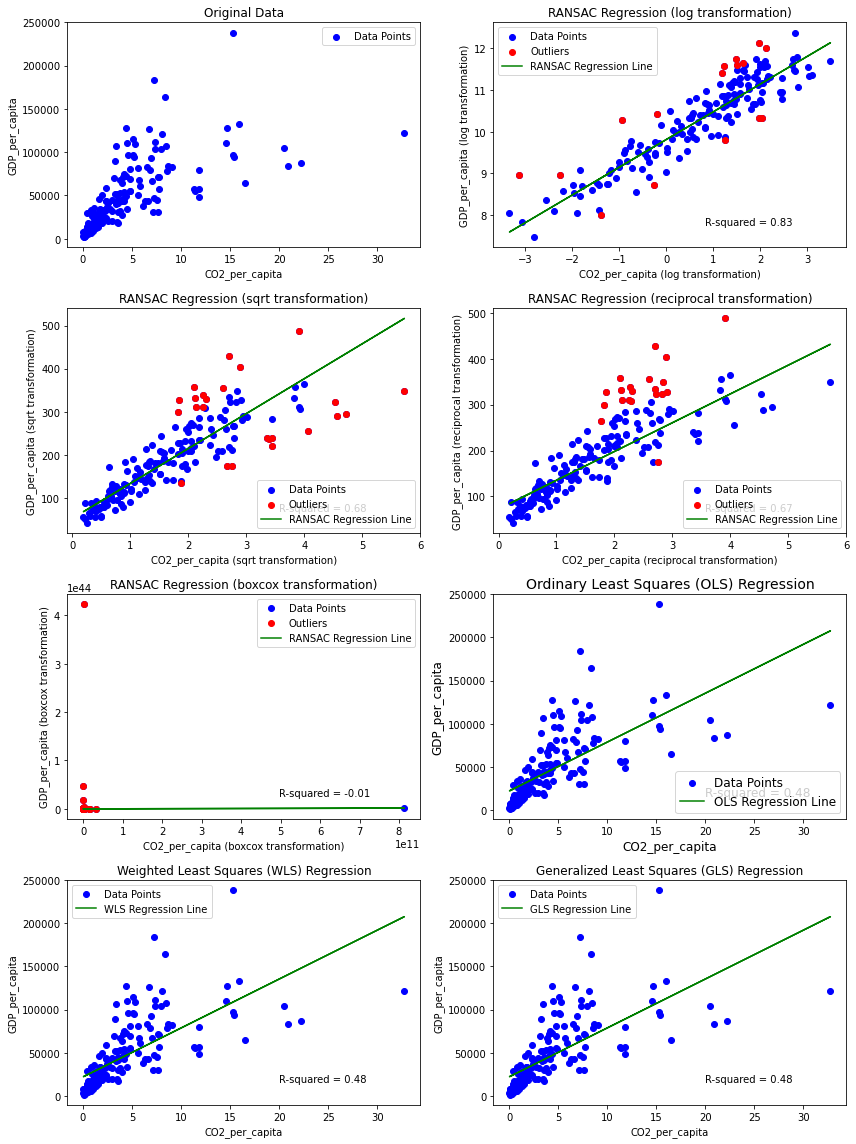

In [97]:
plot_ransac_regression9(df_original, "CO2_per_capita",	"GDP_per_capita")

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm

def plot_ransac_regression10(data, column1, column2):
    transformations = ['log', 'sqrt', 'reciprocal']

    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    fig.tight_layout()

    # Plot original data
    axs[0, 0].scatter(data[column1], data[column2], color='blue', label='Data Points')
    axs[0, 0].set_xlabel(column1)
    axs[0, 0].set_ylabel(column2)
    axs[0, 0].set_title('Original Data')
    axs[0, 0].legend()

    for i, transformation in enumerate(transformations):
        # Apply data transformation
        if transformation == 'log':
            transformed_x = np.log(data[column1])
            transformed_y = np.log(data[column2])
        elif transformation == 'sqrt':
            transformed_x = np.sqrt(data[column1])
            transformed_y = np.sqrt(data[column2])
        elif transformation == 'reciprocal':
            transformed_x = 1 / data[column1]
            transformed_y = 1 / data[column2]
        else:
            continue

        # Drop NaN values
        transformed_data = pd.DataFrame({'X': transformed_x, 'Y': transformed_y})
        transformed_data = transformed_data.dropna()

        # Fit a RANSACRegressor model to the transformed data
        ransac = RANSACRegressor()
        ransac.fit(transformed_data['X'].values.reshape(-1, 1), transformed_data['Y'].values)

        # Obtain the inlier and outlier mask
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)

        # Extract the inlier and outlier data points
        inliers_x = transformed_data['X'][inlier_mask]
        inliers_y = transformed_data['Y'][inlier_mask]
        outliers_x = transformed_data['X'][outlier_mask]
        outliers_y = transformed_data['Y'][outlier_mask]

        # Calculate the R-squared score for the regression line
        r2 = ransac.score(transformed_data['X'].values.reshape(-1, 1), transformed_data['Y'].values)

        # Visualize the data points, regression line, and annotate the R-squared score
        row = (i + 1) // 3
        col = (i + 1) % 3
        axs[row, col].scatter(transformed_x, transformed_y, color='blue', label='Data Points')
        axs[row, col].scatter(outliers_x, outliers_y, color='red', label='Outliers')
        valid_mask = ~np.isnan(transformed_x)
        transformed_x_values = transformed_x if isinstance(transformed_x, np.ndarray) else transformed_x.values
        axs[row, col].plot(transformed_x_values[valid_mask].reshape(-1, 1), ransac.predict(transformed_x_values[valid_mask].reshape(-1, 1)),
                           color='green', label='RANSAC Regression Line')
        axs[row, col].set_xlabel(column1 + ' (' + transformation + ' transformation)')
        axs[row, col].set_ylabel(column2 + ' (' + transformation + ' transformation)')
        axs[row, col].set_title('RANSAC Regression (' + transformation + ' transformation)')
        axs[row, col].annotate(f'R-squared = {r2:.2f}', xy=(0.6, 0.1), xycoords='axes fraction')
        axs[row, col].legend()

    # Drop rows with missing values
    data = data.dropna(subset=[column1, column2])

    # Ordinary Least Squares (OLS)
    ols = sm.OLS(data[column2], sm.add_constant(data[column1])).fit()
    ols_pred = ols.predict(sm.add_constant(data[column1]))
    r2_ols = r2_score(data[column2], ols_pred)
    axs[-1, 0].scatter(data[column1], data[column2], color='blue', label='Data Points')
    axs[-1, 0].plot(data[column1], ols_pred, color='green', label='OLS Regression Line')
    axs[-1, 0].set_xlabel(column1)
    axs[-1, 0].set_ylabel(column2)
    axs[-1, 0].set_title('Ordinary Least Squares (OLS) Regression')
    axs[-1, 0].annotate(f'R-squared = {r2_ols:.2f}', xy=(0.6, 0.1), xycoords='axes fraction')
    axs[-1, 0].legend()

    # Weighted Least Squares (WLS)
    weights_wls = 1 / data[column1]  # Modify weights calculation as needed
    wls = sm.WLS(data[column2], sm.add_constant(data[column1]), weights=weights_wls).fit()
    wls_pred = wls.predict(sm.add_constant(data[column1]))
    r2_wls = r2_score(data[column2], wls_pred)
    axs[-1, 1].scatter(data[column1], data[column2], color='blue', label='Data Points')
    axs[-1, 1].plot(data[column1], wls_pred, color='green', label='WLS Regression Line')
    axs[-1, 1].set_xlabel(column1)
    axs[-1, 1].set_ylabel(column2)
    axs[-1, 1].set_title('Weighted Least Squares (WLS) Regression')
    axs[-1, 1].annotate(f'R-squared = {r2_wls:.2f}', xy=(0.6, 0.1), xycoords='axes fraction')
    axs[-1, 1].legend()

    # Generalized Least Squares (GLS)
    weights_gls = 1 / data[column1]  # Modify weights calculation as needed
    gls = sm.GLS(data[column2], sm.add_constant(data[column1]), weights=weights_gls).fit()
    gls_pred = gls.predict(sm.add_constant(data[column1]))
    r2_gls = r2_score(data[column2], gls_pred)
    axs[-1, 2].scatter(data[column1], data[column2], color='blue', label='Data Points')
    axs[-1, 2].plot(data[column1], gls_pred, color='green', label='GLS Regression Line')
    axs[-1, 2].set_xlabel(column1)
    axs[-1, 2].set_ylabel(column2)
    axs[-1, 2].set_title('Generalized Least Squares (GLS) Regression')
    axs[-1, 2].annotate(f'R-squared = {r2_gls:.2f}', xy=(0.6, 0.1), xycoords='axes fraction')
    axs[-1, 2].legend()

    plt.tight_layout()
    plt.show()



C:\Users\StefanRaychev\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


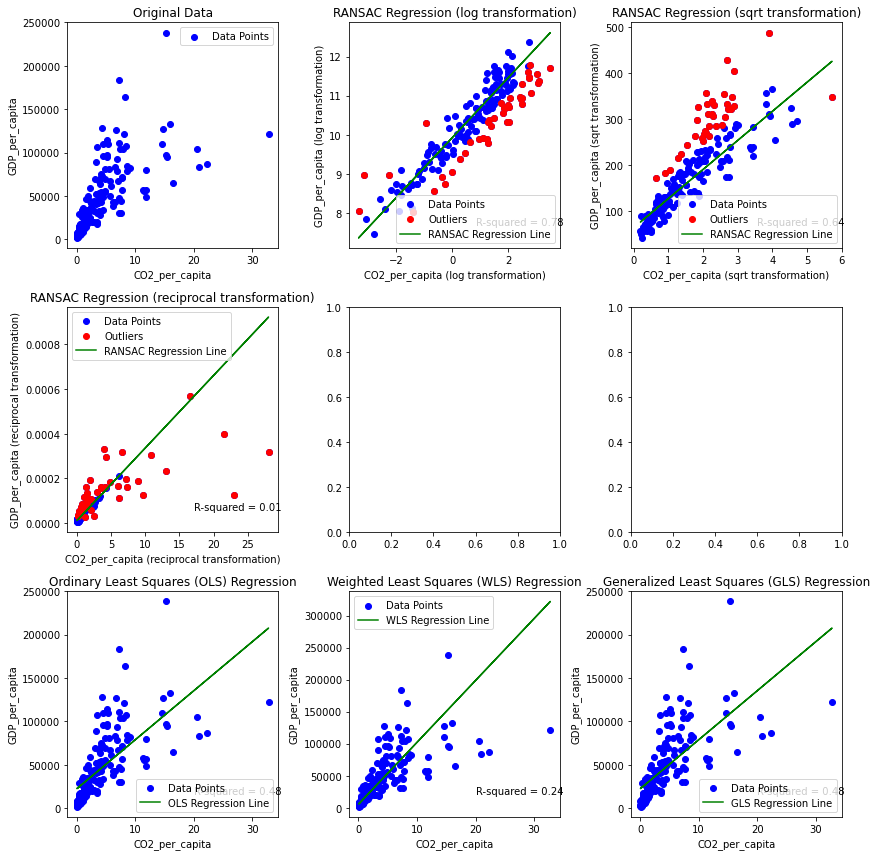

In [103]:
plot_ransac_regression10(df_original, "CO2_per_capita",	"GDP_per_capita")